In [1]:
%pylab inline
import pandas as pd

import autograd.numpy as np
from autograd import grad

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

# This is important
Y = (Y.T - Y.mean(1)).T
Y = (Y.T / Y.std(1)).T

In [60]:
from SpatialDE import base

In [61]:
K = base.SE_kernel(X, 1.)
s2e = 1.
C = 5
G = Y.shape[0]
N = Y.shape[1]

In [62]:
def Q_Z_expectation(mu, Y, s2e, N, C, G, pi=None):
    if pi is None:
        pi = np.ones(C) / C

    log_rho = np.log(pi[None, :]) \
              - 0.5 * np.sum((mu.T[None, :, :] - Y[:, None, :]) ** 2, 2) / s2e \
              - 0.5 * N * np.log(2 * np.pi)

    # Subtract max per row for numerical stability
    rho = np.exp(log_rho - log_rho.max(1)[:, None])
    r = (rho.T / (rho.sum(1))).T
    
    return r

In [63]:
def Q_mu_k_expectation(Z_k, Y, K, s2e):
    y_k_tilde = Z_k.dot(Y) / s2e
    Sytk = K.dot(y_k_tilde)
    IpSDk = np.eye(K.shape[0]) + K * Z_k.sum() / s2e
    m_k = np.linalg.solve(IpSDk, Sytk)
    
    return m_k

def Q_mu_expectation(Z, Y, K, s2e):
    m = np.zeros((Y.shape[1], Z.shape[1]))

    y_k_tilde = Z.T.dot(Y).T / s2e

    for k in range(Z.shape[1]):
        m[:, k] = Q_mu_k_expectation(Z[:, k], Y, K, s2e)

    return m

In [64]:
# Expecation of ln P(Y | Z, mu, s2e)
def ln_P_YZms(Y, Z, mu, s2e, pi=None):
    G = Y.shape[0]
    C = Z.shape[1]
    if pi is None:
        pi = np.ones(C) / C
    
    log_rho = np.log(pi[None, :]) \
              - 0.5 * np.sum((mu.T[None, :, :] - Y[:, None, :]) ** 2, 2) / s2e \
              - 0.5 * N * np.log(2 * np.pi)
            
    return (Z * log_rho).sum()

# Expectation of ln P(Z)
def ln_P_Z(Z, pi=None):
    C = Z.shape[1]
    if pi is None:
        pi = np.ones(C) / C
        
    return Z.dot(np.log(pi)).sum()

# Expectation of ln P(mu)

def ln_P_mu(mu, K):
    N = K.shape[0]
    C = mu.shape[1]
    ll = 0
    U, S = base.factor(K)
    for k in range(C):
        ll = ll + np.sum(np.log(S)) \
            + mu[:, k].dot(np.linalg.solve(K, mu[:, k])) \
            + N * np.log(2 * np.pi)
        
    ll = -0.5 * ll
    
    return ll

# Expectation of ln Q(Z)
def ln_Q_Z(Z, r):
    return np.sum(Z * np.log(r))

# Expecation of ln Q(mu)
def ln_Q_mu(K, Z, s2e):
    N = K.shape[0]
    C = Z.shape[1]
    G_k = Z.sum(0)
    
    ll = 0
    U, S = base.factor(K)
    for k in range(C):
        det_W_inv = (1. / S).sum() + N * G_k[k] / s2e
        ll = ll + np.log(1. / det_W_inv) + N * np.log(2 * np.pi)
        
    
    ll = -0.5 * ll
    
    return ll

In [65]:
def ELBO(Y, r, m, s2e, K, pi=None):
    L = ln_P_YZms(Y, r, m, s2e, pi) + ln_P_Z(r, pi) + ln_P_mu(m, K) \
        - ln_Q_Z(r, r) - ln_Q_mu(K, r, s2e)
    
    return L

In [86]:
xx = np.logspace(-4, 4)
yy = [ELBO(Y, r, m, ss, K) for ss in xx]

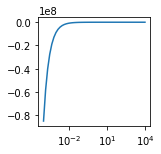

In [89]:
plt.xscale('log')
plt.plot(xx, yy);

In [90]:
def make_elbojective(Y, r, m, X, pi=None):
    def elbojective(xx):
        log_l = xx[0]
        log_s2e = xx[1]
        K = base.SE_kernel(X, np.exp(log_l))
        return -ELBO(Y, r, m, np.exp(log_s2e), K, pi)
    
    return elbojective

In [91]:
from scipy import optimize

In [104]:
def fit_patterns(C, Y, X, l, s2e, print_elbo=False, maxiter=10, printerval=1, opterval=1):
    G = Y.shape[0]
    
    l_init = l
    s2e_init = s2e
    
    l_min, l_max = base.get_l_limits(X)
    l_min, l_max = l_min * 1, l_max / 1
    
    print(l_min, l_max)
    
    r = np.random.uniform(size=(G, C))
    r = r / r.sum(0)
    
#     pi = r.sum(0) / G
    pi = None

    K = base.SE_kernel(X, l)
    m = Q_mu_expectation(r, Y, K, s2e)

    if print_elbo:
        print('iter ', 0, 'ELBO: ', ELBO(Y, r, m, s2e, K, pi))

    fgrad = 'not now'
    for i in range(maxiter):
        if (i % opterval == (opterval - 1)):
            elbojective = make_elbojective(Y, r, m, X, pi)
            x0 = np.array([np.log(l_init), np.log(s2e_init)])
            fgrad = grad(elbojective)(x0)
            o = optimize.minimize(elbojective, x0,
                                  method='L-BFGS-B',
                                  jac=grad(elbojective),
                                  bounds=[(np.log(l_min), np.log(l_max)),
                                          (-2., 2.)])
            
            l = np.exp(o.x[0])
            s2e = np.exp(o.x[1])
            
            K = base.SE_kernel(X, l)
            
            
        m = Q_mu_expectation(r, Y, K, s2e)
        r = Q_Z_expectation(m, Y, s2e, N, C, G, pi)
        
#         pi = r.sum(0) / G
        pi = None

        if print_elbo and (i % printerval == 0):
            print('iter ', i + 1, 'ELBO: ', ELBO(Y, r, m, s2e, K, pi), [np.log(l), np.log(s2e)], fgrad)


    return ELBO(Y, r, m, s2e, K, pi), m, r, s2e, l

In [105]:
C = 5
elbo, m, r, s2e, l = fit_patterns(C, Y, X, 2., 1., True, maxiter=10, printerval=1, opterval=1)

K = base.SE_kernel(X, l)

0.402001243779 42.9549317774
iter  0 ELBO:  2644.54917621
iter  1 ELBO:  -5778.25698579 [3.7601514678542647, 2.0] [-8176.7972641   -633.60957403]
iter  2 ELBO:  -5777.80337254 [3.7601514678542647, 2.0] [-8183.41397714 -8707.06218048]
iter  3 ELBO:  -5777.80299671 [3.7601514678542647, 2.0] [-8183.41178542 -8701.96211844]
iter  4 ELBO:  -5777.80297578 [3.7601514678542647, 2.0] [-8183.4117807  -8701.96069855]
iter  5 ELBO:  -5777.80297419 [3.7601514678542647, 2.0] [-8183.41178051 -8701.96063918]
iter  6 ELBO:  -5777.80297403 [3.7601514678542647, 2.0] [-8183.41178055 -8701.9606363 ]
iter  7 ELBO:  -5777.80297401 [3.7601514678542647, 2.0] [-8183.41178048 -8701.96063612]
iter  8 ELBO:  -5777.80297401 [3.7601514678542647, 2.0] [-8183.41178051 -8701.96063611]
iter  9 ELBO:  -5777.80297401 [3.7601514678542647, 2.0] [-8183.41178052 -8701.9606361 ]
iter  10 ELBO:  -5777.80297401 [3.7601514678542647, 2.0] [-8183.41178051 -8701.9606361 ]


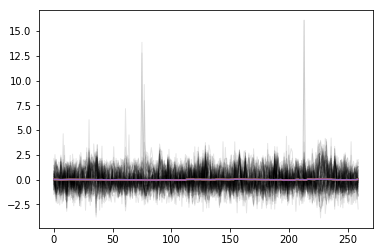

In [94]:
figsize(6, 4)
for g in range(G):
    plt.plot(range(Y.shape[1]), Y[g], lw=1, c='k', alpha=0.1)
    
plt.plot(m);

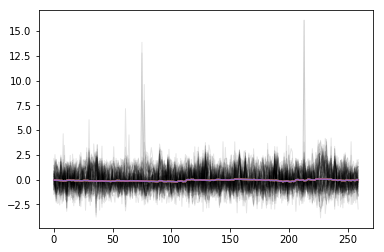

In [95]:
figsize(6, 4)
for g in range(G):
    plt.plot(range(Y.shape[1]), Y[g], lw=1, c='k', alpha=0.1)
    
plt.plot(K.dot(m));

In [96]:
sres['pattern'] = r.argmax(1)

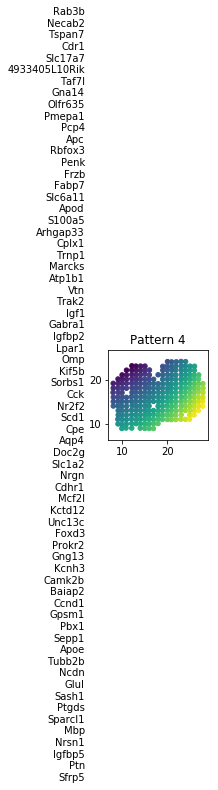

In [97]:
figsize(2, 2)
for k in np.unique(r.argmax(1)):
    plt.figure()
#     plt.scatter(X[:, 0], X[:, 1], c=K.dot(m[:, k]), s=20)
    plt.scatter(X[:, 0], X[:, 1], c=(m[:, k]), s=20)
    plt.axis('equal')
    plt.title('Pattern {}'.format(k + 1))
    plt.tight_layout()
    plt.ylabel('\n'.join(sres.query('pattern == @k')['g']), rotation=0, va='center', ha='right')